**Preamble**

This is a **group** assignment. Please indicate the names of all group members below. 
Each group is to comprise *four* to *five* members.

If the group obtains a solution through research (e.g., on the web), then the group is to acknowledge the source, but *write up the solution in their OWN WORDS*.

## Traveling Salesperson Problem (TSP)

If you need help on using iPython notebooks, click <a href='#help'>here</a>. 

Assignment objectives:

i. Using PuLP and techniques from Dantzig, Fulkerson, Johnson (refer to lecture notes),
implement a routine to compute a lower bound for a TSP instance.

ii. Using the implemented routine, obtain tight estimates on two TSP instances.

**(a) (5 marks)** Implement a routine in PuLP that computes a lower bound for a TSP instance.

Specifically, your routine should take as 

**inputs:**

- a list of `cities`,
- a distance dictionary `dist`,
- a list of subtours `S`,

and **output** a number $L_1$ such that the shortest TSP tour for `cities`, `dist` is at least $L_1$. 

<span style='color:blue'>For the example below, your routine should compute $L_1$ to be $32$.</span>

In [94]:
# Example 2 in Dantzig, Fulkerson, Johnson
# See example in class notes

cities = [1,2,3,4,5]
dist = {
               (1,2): 5,  (1,3): 6,  (1,4): 10, (1,5):8,
    (2,1): 5,             (2,3): 5,  (2,4): 12, (2,5):12,
    (3,1): 6,  (3,2): 5,             (3,4): 8,  (3,5):10,
    (4,1): 10, (4,2): 12, (4,3): 8,             (4,5):6,
    (5,1): 8,  (5,2): 12, (5,3): 10, (5,4):6,   
}

S = [
    [4,5]
]

In [99]:
from pulp import *

# Helper functions
def Identify_One_Subtour(subtour_cities, X_ij_s):
    
    '''
    Helper function:
        Generate one subtour and return it,
        it doesn't matter starting from which city
    '''
    
    ret_tour = list()
    subtour_cities_copy = subtour_cities.copy()
    
    start_city = subtour_cities[0]
    ret_tour.append(subtour_cities_copy.pop(subtour_cities_copy.index(start_city)))
    
    found_subtour = False
    
    while len(subtour_cities_copy) > 0 and not found_subtour:
        for i in subtour_cities_copy:
            if X_ij_s[(start_city,i)].varValue ==1:
                ret_tour.append(subtour_cities_copy.pop(subtour_cities_copy.index(i)))
                start_city = i
                break
            else:
                # reaches end, but couldn't find a link, identified end of a subtour
                if i == subtour_cities_copy[-1]:
                    found_subtour = True
                    
    ret_tour.append(subtour_cities[0])
    return ret_tour
            
def Identify_All_Subtours(list_cities, X_ij_s):
    
    '''
    Helper function:
        Based on decision variable's value, 
        identify the list of subtours INCLUDING the main tour
    '''
    
    list_cities_copy = list_cities.copy()
    
    # container to hold list of subtours
    ret_tours = list()
    
    while len(list_cities_copy) > 0:
        ret_tour = Identify_One_Subtour(list_cities_copy, X_ij_s)
        ret_tours.append(ret_tour)
        list_cities_copy = list(set(list_cities_copy) - set(ret_tour))
        
    return ret_tours

def Print_Cities_With_Linkage(list_cities, X_ij_s):
    for i in list_cities:
        for j in list_cities:
            if ((i,j) in X_ij_s) and (X_ij_s[(i,j)].varValue == 1):
                print(i, " to ", j, " with value of ", X_ij_s[(i,j)].varValue)
    print('\n')
    

In [100]:
############################
# Part (a) Required Routine
############################

def Tsp_L1(list_cities, dict_distances, list_subtour, ignore_subtour = False):
    
    '''
    This function takes the following params
        @list_cities: the collect of cities
        @ict_dist: the collection inter-city distances
        @ist_subtour: the list of subtour, each subtour is also a list of cities
    '''
    # problem
    tspProb = LpProblem("TSP", LpMinimize)

#???????????????????????????????????????????????????????????????????????????????    
    ###### [TODO] current using LpBinary which allows for only 0 and 1, which might not be desired
    ###### later probably have to change it to allow fractional according to the lecture notes.
#???????????????????????????????????????????????????????????????????????????????
    # decision variables
    #X_ij_s = LpVariable.dicts('DecisionVariables', dict_distances, 0, 1, cat=LpContinuous)  # from 0 to 1 of Continous
    X_ij_s = LpVariable.dicts('DecisionVariables', dict_distances, 0, 1, cat = LpBinary)  # either 0 or 1 of binary
    

    # cost 
    C_ij_s = lpSum([X_ij_s[(i,j)] * dict_distances[(i,j)]] for (i,j) in dict_distances)

    # update the prob
    tspProb  += C_ij_s

    # add the constraints
    for i in list_cities:
                     # all inbound to city i should sum up to 1
        tspProb += ( lpSum([ X_ij_s[(from_city, i)] for from_city in list_cities if (from_city, i) in X_ij_s]) 
                     # all outbound from city i should sum up to 1
                   + lpSum([ X_ij_s[(i, to_city)] for to_city in list_cities if (i, to_city) in X_ij_s]) 
                     # hence 2 here
                   == 2)
    
    if not ignore_subtour:
        # iterate thru each subtour and add the contraints 
        ## declare a list to hold the cities that are not within any of the subtours
        ## and we are going to eliminate the all the subtours one by one, hence the size list_non_subtour
        ## will be increased each time a subtour is eliminated
        list_non_subtour = list()
    
        for subtour in list_subtour:
            list_non_subtour = list(set(cities) - set(subtour))
        
            # for each subtour make sure the numbers of links to each city in the subtour >=1
            for i in subtour:
                tspProb += (lpSum([ X_ij_s[(non_subtour_city, i)] for non_subtour_city in list_non_subtour 
                                   if (non_subtour_city, i) in X_ij_s]) >= 1)
        
#??????????????? [TODO, i have doubt on this step, check later, 
            ##### is it possible to generate new subtour whilst eliminating one] 
#???????????????????????????????????????????????????????????????????????????????
            # merge the eliminated subtour back to list_non_subtour
            list_non_subtour += subtour

    tspProb.solve()
    #print(tspProb)
    #print(LpStatus[tspProb.status])
    print("Minimum Cost: {}".format(value(tspProb.objective)))
                    
    return X_ij_s

# try solving it first by ignoring subtour
X_ij_s = Tsp_L1(cities, dist, S, True) # this is to verify the subtour is indeed [4,5]
Print_Cities_With_Linkage(cities, X_ij_s)
print(Identify_All_Subtours(cities, X_ij_s))

print('\n')

# including subtours, and verify if it's 32
X_ij_s1 = Tsp_L1(cities, dist, S)
Print_Cities_With_Linkage(cities, X_ij_s1)
print(Identify_One_Subtour(cities, X_ij_s1))

Minimum Cost: 28.0
1  to  2  with value of  1.0
1  to  3  with value of  1.0
2  to  3  with value of  1.0
4  to  5  with value of  1.0
5  to  4  with value of  1.0


[[1, 2, 3, 1], [4, 5, 4]]


Minimum Cost: 32.0
1  to  2  with value of  1.0
1  to  5  with value of  1.0
2  to  3  with value of  1.0
3  to  4  with value of  1.0
4  to  5  with value of  1.0


[1, 2, 3, 4, 5, 1]


----

**(b) (10 marks)** 

For each of the two given instances, let $L^*$ be the length of a shortest TSP tour.

Using the routine in (a) (and some appropriate choices of `S`), compute a lower bound $L_1$.
From the solution in (a), guess a 'short' TSP tour and hence, obtain an upper bound $L_2$.
Therefore, 
$$L_1\le L^*\le L_2.$$

The marks to be awarded will depend the quality of your estimates, or equivalently, the ratio $L_2/L_1$. The specific mark allocation for each TSP instance is as follows.

|  &nbsp; &nbsp; &nbsp; &nbsp; Ratio $R=L_2/L_1$ &nbsp;  &nbsp; &nbsp; &nbsp;   |  Mark(s)    |
|:--------------------:|:-----------:| 
| $R>1.5$              | 0|
| $1.1 < R \le 1.5$    | 2 |
| $1.05 < R \le 1.1$ | 3 |
| $1.01 < R \le 1.05$ | 4 |
| $R \le 1.01$ | 5 |



## TSP B1

In [ ]:
# Question B1

from TSP_B1 import *
import pulp

print("number of cities : {}".format(len(cities_B1)))

# WRITE YOUR CODE HERE

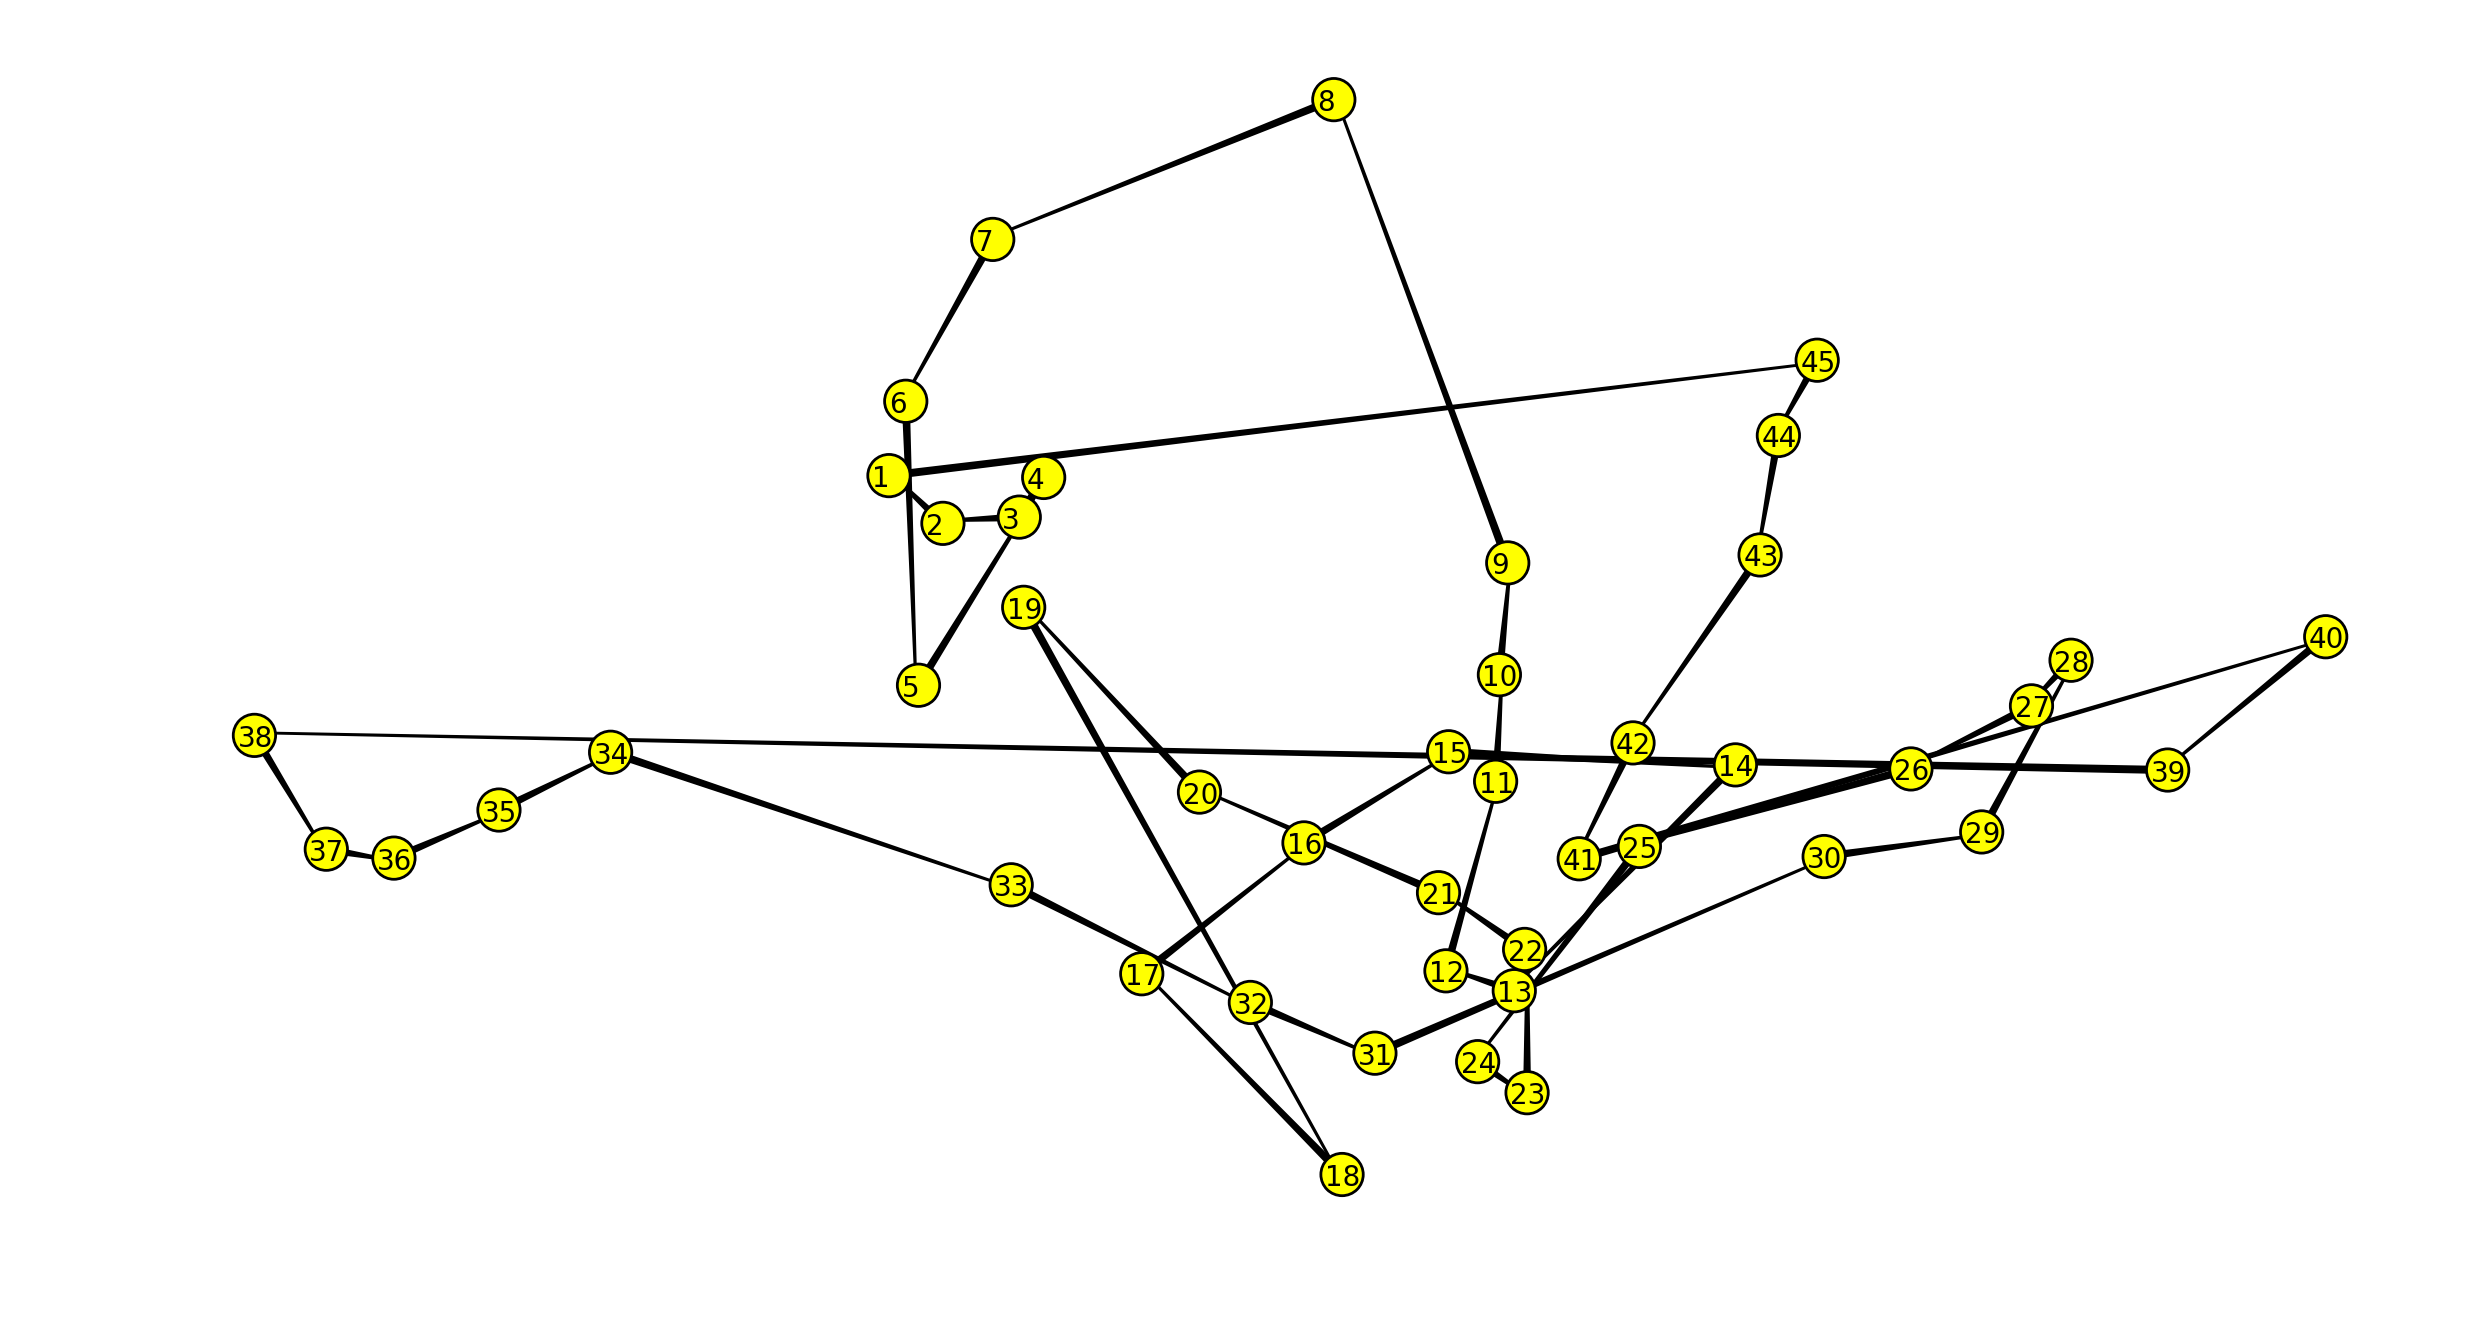

length of candidate TSP tour : 2290


In [12]:
# you can change this tour

candidate_tour = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
    31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
    41, 42, 43, 44, 45    
]


# auxiliary function that plots out a candidate TSP tour 
#                     and computes its length

L2 = TSP_plot(candidate_tour,cities_B1,posn_B1,dist_B1)

print("length of candidate TSP tour : {}".format(L2))


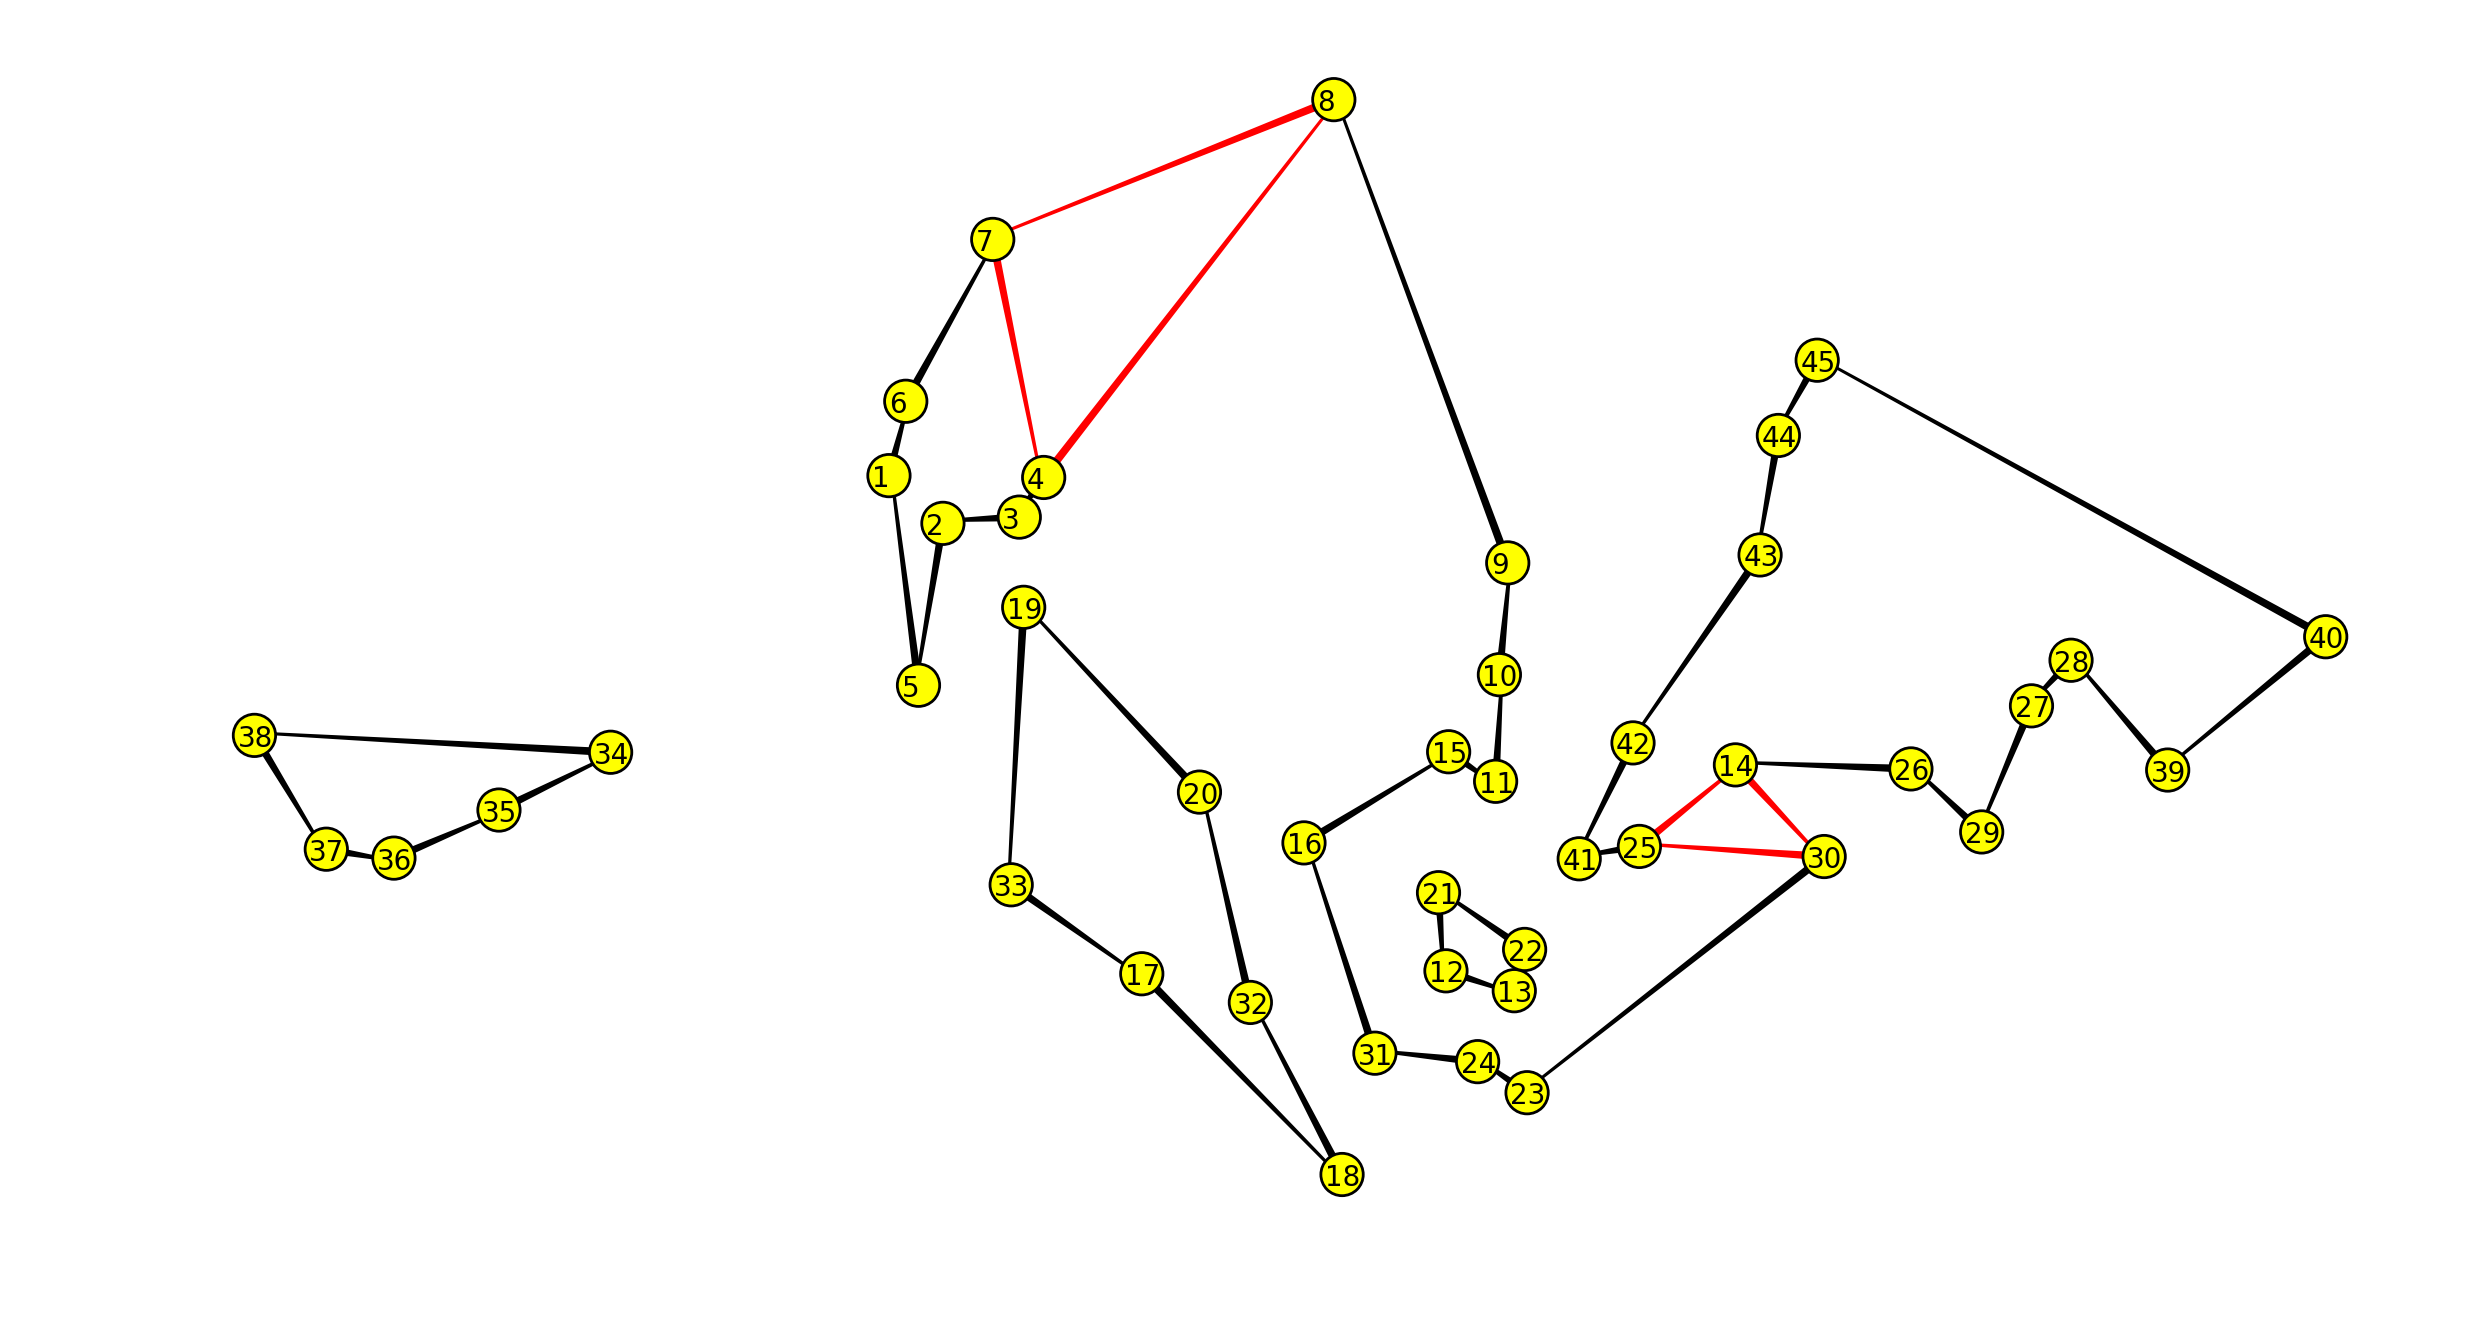

In [13]:
# auxiliary function that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional values, and plotted in red 


E = [
    (7,6),(6,1),(1,5),(5,2),(2,3),(3,4), (8, 9), (9, 10), (10, 11),
    (11, 15), (15, 16), (16, 31), (31, 24), (24, 23), 
    (19, 20), (20, 32), (32, 18), (18, 17), (17, 33), (33, 19), (14,26),
    (21, 22), (22, 13), (13, 12), (12, 21), (23, 30),
    (34, 35), (35, 36), (36, 37), (37, 38), (38, 34),
    (41, 42), (42, 43), (43, 44), (44, 45), (45, 40),
    (26, 29), (29, 27), (27, 28), (28, 39), (39, 40), (41, 25),
]

fE = [
    (4,7),(7,8),(8,4), (14,25), (25,30),(30,14),
]

LL = frac_TSP_plot(E,fE,cities_B1,posn_B1,dist_B1)


length of fractional TSP tour (or TSP_LP solution) : 1434.0


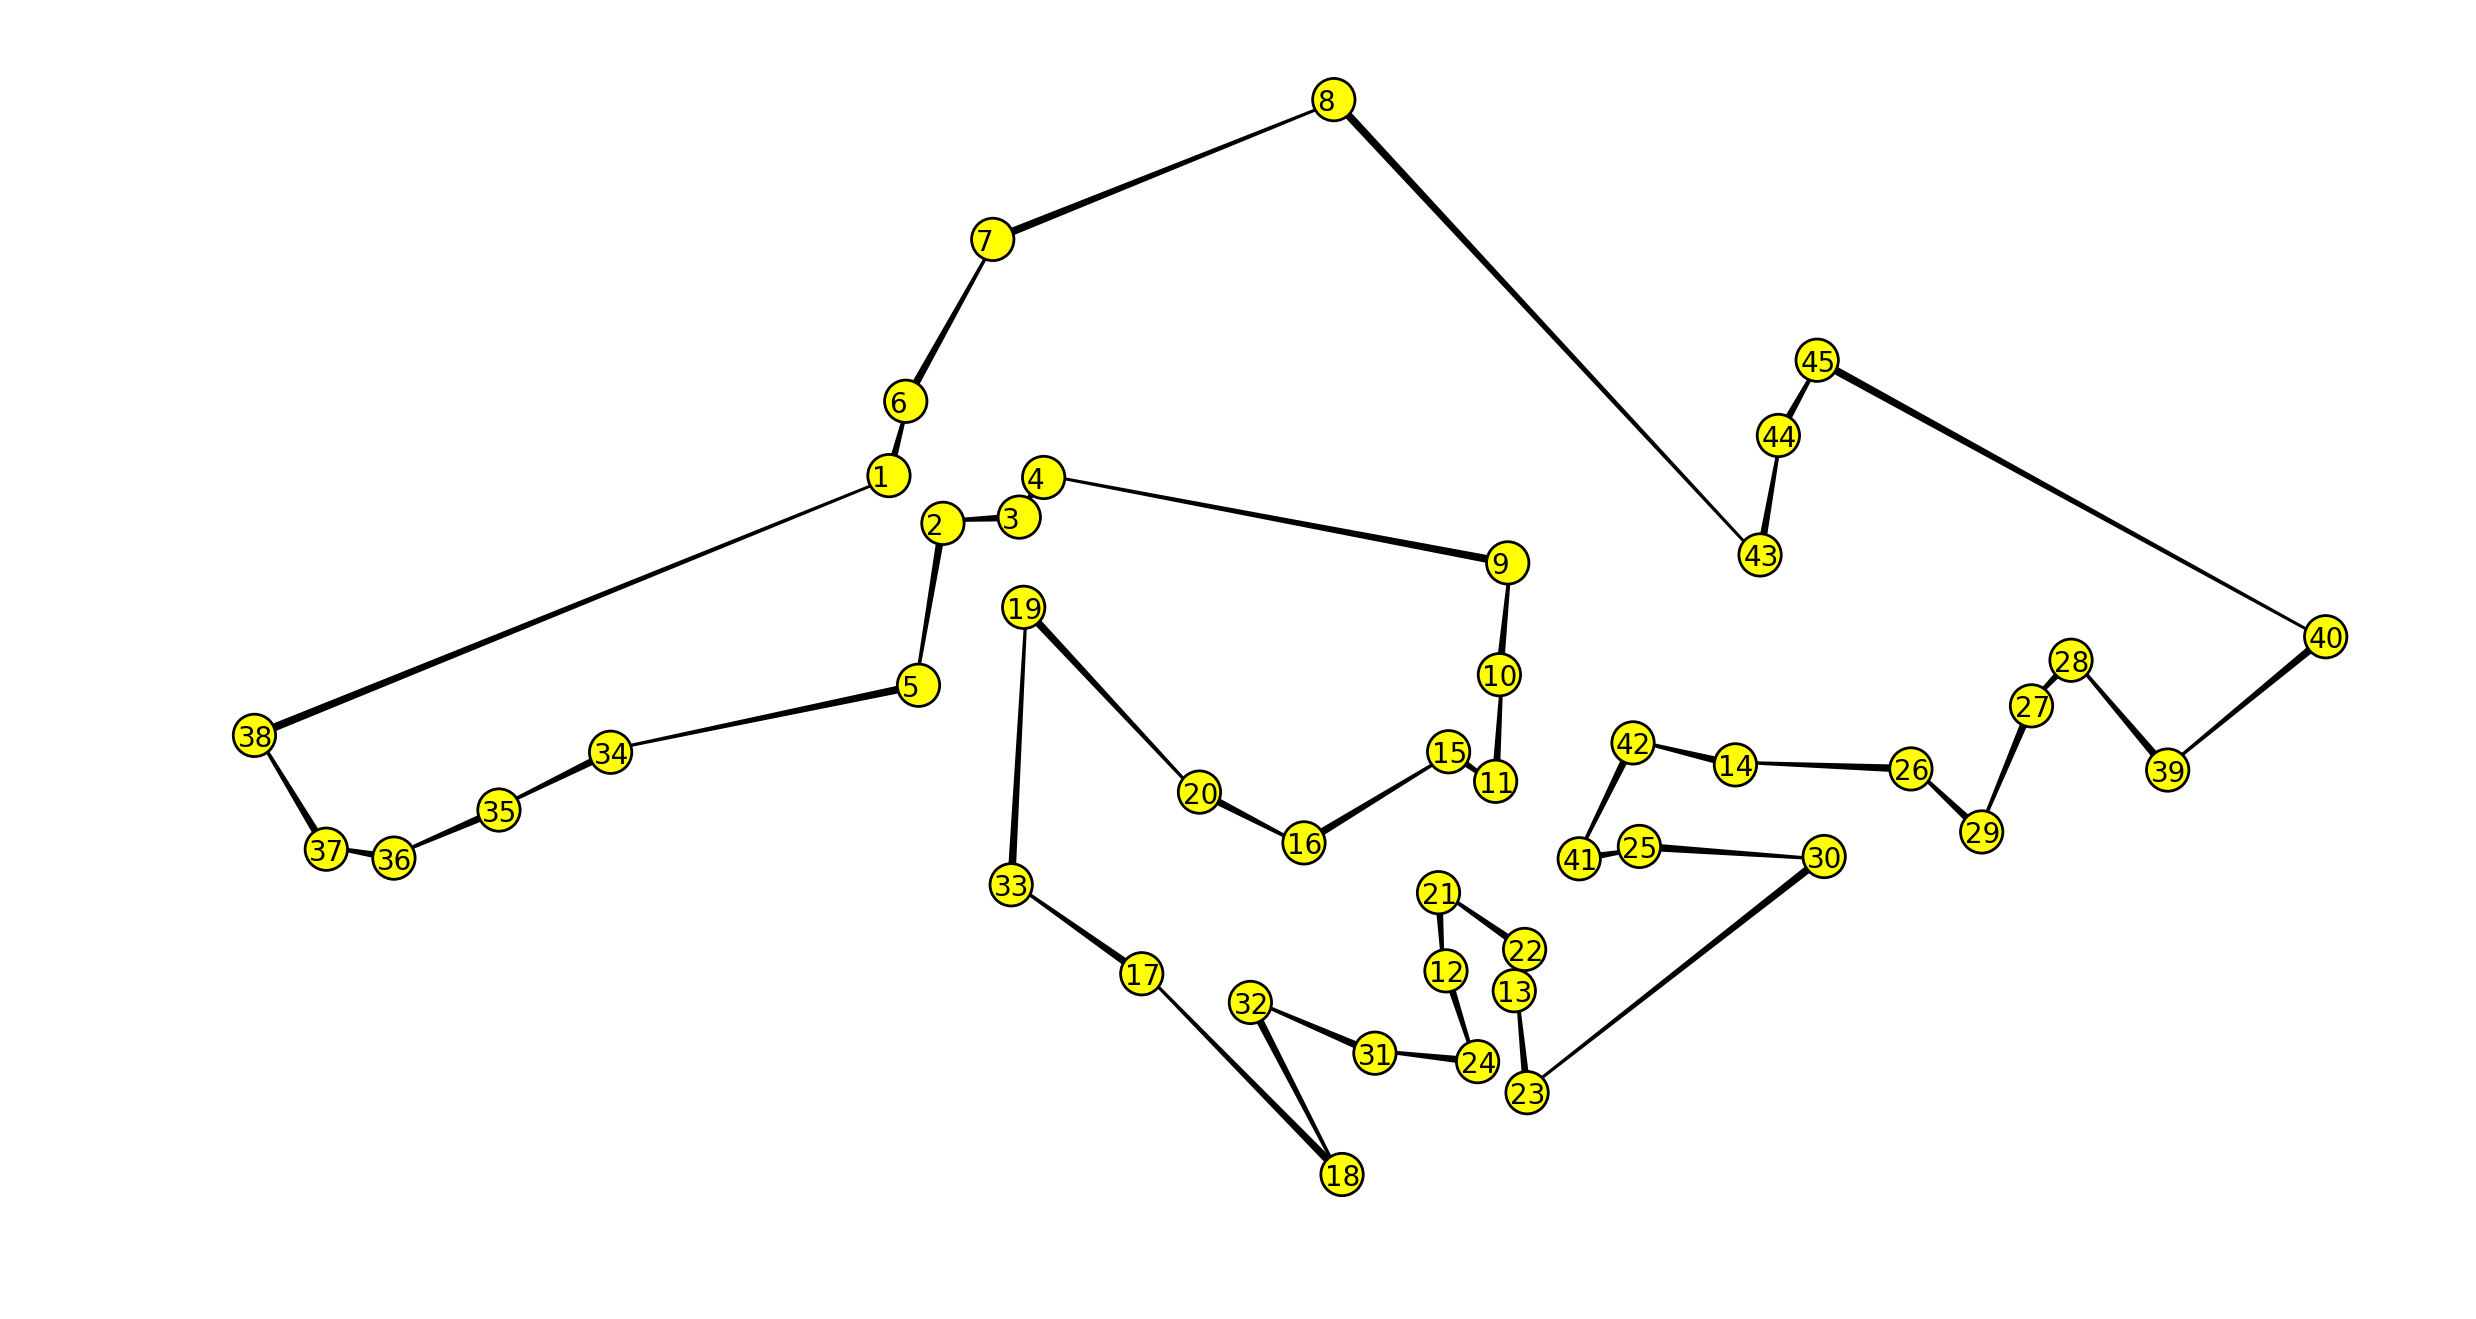

length of candidate TSP tour : 1545


In [11]:
# you can change this tour

candidate_tour2 = [
    8, 7, 6, 1, 
    38, 37, 36, 35, 34, 
    5, 2, 3, 4,  
    9, 10, 11, 15, 16, 
    20, 19, 33, 17, 18, 32,
    31, 24, 12, 21, 22, 13, 23,
    30, 25, 41, 42, 14, 26, 29, 27, 28, 39, 40, 45, 44, 43
]

L2 = TSP_plot(candidate_tour2,cities_B1,posn_B1,dist_B1)

print("length of candidate TSP tour : {}".format(L2))

## TSP B2

In [45]:
# Question B2

from TSP_B2 import *
import pulp

print("number of cities : {}".format(len(cities_B2)))

# you can change this tour

candidate_tour = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
    31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
    41, 42, 43, 44, 45    
]


# auxiliary function that plots out a candidate TSP tour 
#                     and computes its length

L2 = TSP_plot(candidate_tour,cities_B2,posn_B2,dist_B2)

print("length of candidate TSP tour : {}".format(L2))

# auxiliary function that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional, and plotted in red 


E = [
    (1, 43), (2, 3), (3, 4), (4, 5), (5,29), (29, 28), (28, 6), (6,27), (27, 7), (7, 8), (8, 9), (9, 10), 
    (11, 15), (15, 16), (16, 14), (14, 13), (13, 12),
    (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 37),
    (25, 26), (42, 30), (30, 41), (31, 32), (31, 41), 
    (34, 35), (35, 36), (37, 38), (38, 39), (39, 40), 
    (41, 30), (42, 1), (43, 45), (44, 2), (45,44),(40,26),(25,32),
]

fE = [
    (12,17),(17,11),(11,12),  (10,34),(34,36),(36,10)
]

LL = frac_TSP_plot(E,fE,cities_B2,posn_B2,dist_B2)


print("length of fractional TSP tour : {}".format(LL))



# WRITE YOUR CODE HERE

number of cities : 45


NameError: name 'TSP_plot' is not defined

---

## Auxilliary Plotting Functions

In [9]:
# Auxiliary function that
# plots out a candidate TSP tour 
# and computes its length


import matplotlib.pyplot as plt
import math as math
from matplotlib import collections as mc


def TSP_plot(tour,cities,posn,dist):
    fig = plt.figure()
    fig.set_dpi(200)
    fig.set_size_inches(15,30)

    r = 400
    xoffset=-0.8*r
    yoffset=-0.5*r
    displayname = 0

    for city in cities:

        center = posn[city]

        circle = plt.Circle(center, r, ec='black',fc='yellow', zorder = 9)
        plt.text(center[0]+xoffset,center[1]+yoffset,city, zorder=10)
        plt.gca().add_patch(circle)
    
    N = len(cities)
    
    L = 0
    for i in range(N):
        u = tour[i]
        if i<N-1: v = tour[i+1]
        else: v = tour[0]
            
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='k',width=100,head_width=0, zorder=1)
        
        L += dist[(u,v)]
        
    plt.axis('scaled')
    plt.axis('off')
    plt.show()
    
    return L

In [3]:
# Auxiliary functions that plots out a fractional TSP tour 
#   E  : list of edges with values one, and plotted in black 
#   fE : list of edges with fractional, and plotted in red 

import matplotlib.pyplot as plt
import math as math
from matplotlib import collections  as mc


def frac_TSP_plot(E,fE,cities,posn,dist):
    fig = plt.figure()
    fig.set_dpi(200)
    fig.set_size_inches(15,30)

    r = 400
    xoffset=-0.8*r
    yoffset=-0.5*r
    displayname = 0

    for city in cities:

        center = posn[city]

        circle = plt.Circle(center, r, ec='black',fc='yellow', zorder = 9)
        plt.text(center[0]+xoffset,center[1]+yoffset,city, zorder=10)
        plt.gca().add_patch(circle)
    
    L = 0
    
    for (u,v) in E:
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='k',width=100,head_width=0, zorder=1)
        
        L += dist[(u,v)]
    
    for (u,v) in fE:
        ux = posn[u][0]
        uy = posn[u][1]
        vx = posn[v][0]
        vy = posn[v][1]
        plt.arrow(ux,uy,vx-ux,vy-uy,color='red',width=100,head_width=0, zorder=1)
        
        L += 0.5*dist[(u,v)]
    
        
    plt.axis('scaled')
    plt.axis('off')
    plt.show()
    
    return L